# Instalaçoes e bibliotecas necessárias

In [1]:
!pip install unidecode openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.3 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import re
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Carregando dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MiniProjeto/dataset/CorpusTwitchVideojuegos.xlsx")
df = df[['TEXTO', 'Polaridad']].dropna()
#alterar dataset:
#df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MiniProjeto/dataset/CorpusTwitchVideogames_Extension2024.xlsx")

# Função de pré-processamento

In [6]:
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')
tokenizer = TweetTokenizer()

In [7]:
def preprocess(text):
    text = str(text).lower()
    text = unidecode(text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\b(j[aeiou]{1,})+\b', 'jaja', text)
    text = re.sub(r'\bx[o0]+\b', 'pero', text)
    text = re.sub(r'\bxfa\b', 'por favor', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\b(streamlabs|nightbot)\b', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Aplica o pré-processamento

In [8]:
df['clean_text'] = df['TEXTO'].apply(preprocess)

# Vetorização com TF-IDF e preparação de dados


In [9]:
y = df['Polaridad']

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definindo modelos

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',
    random_state=42
)
rf_model.fit(X_train, y_train)

#MEU TESTE: max_features = 'log2', n_estimators = 500
#PARAMETROS DO ARTIGO: max_features = 'sqrt', n_estimators = 500

RandomForestClassifier(n_estimators=500, random_state=42)

In [13]:
svm_model = SVC(C=150, kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

#MEU TESTE: KERNEL RBF, C = 1
#PARAMETROS DO ARTIGO: KERNEL RBF, C = 150

SVC(C=150, random_state=42)

# Realizando predições

In [14]:
rf_pred = rf_model.predict(X_test)


In [15]:
svm_pred = svm_model.predict(X_test)

# Resultados

***relatórios de classificação***

In [16]:
print("\nCLASSIFICAÇÃO RANDOM FOREST")
print(classification_report(y_test, rf_pred))

print("\nCLASSIFICAÇÃO SVM")
print(classification_report(y_test, svm_pred))


CLASSIFICAÇÃO RANDOM FOREST
               precision    recall  f1-score   support

Indeterminado       0.67      0.16      0.26        86
     Negativo       0.58      0.81      0.68       285
     Positivo       0.72      0.60      0.66       294

     accuracy                           0.63       665
    macro avg       0.66      0.53      0.53       665
 weighted avg       0.65      0.63      0.61       665


CLASSIFICAÇÃO SVM
               precision    recall  f1-score   support

Indeterminado       0.68      0.15      0.25        86
     Negativo       0.61      0.82      0.70       285
     Positivo       0.74      0.65      0.69       294

     accuracy                           0.66       665
    macro avg       0.68      0.54      0.55       665
 weighted avg       0.67      0.66      0.64       665



***F1-score***

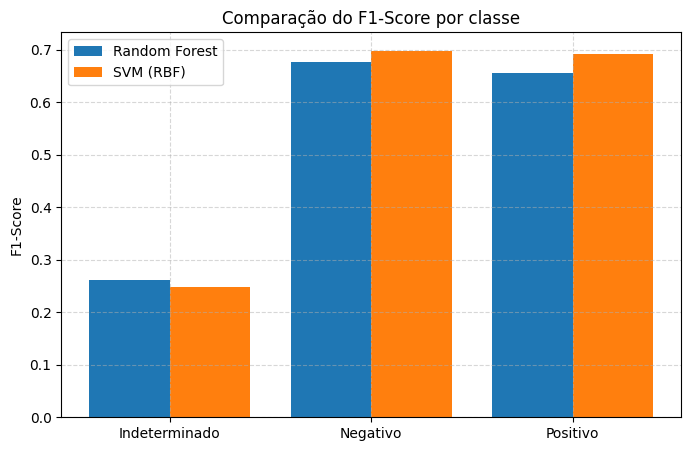

In [17]:
from sklearn.metrics import f1_score

f1_rf = f1_score(y_test, rf_pred, average=None)
f1_svm = f1_score(y_test, svm_pred, average=None)
classes = ['Indeterminado', 'Negativo', 'Positivo']

x = range(len(classes))
plt.figure(figsize=(8, 5))
plt.bar(x, f1_rf, width=0.4, label='Random Forest', align='center')
plt.bar([i + 0.4 for i in x], f1_svm, width=0.4, label='SVM (RBF)', align='center')
plt.xticks([i + 0.2 for i in x], classes)
plt.ylabel('F1-Score')
plt.title('Comparação do F1-Score por classe')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Matrizes de confusão

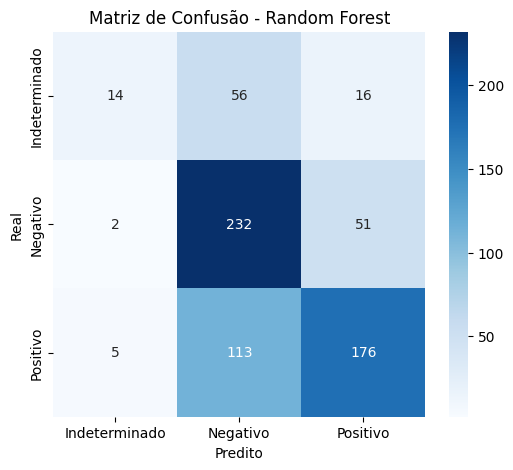

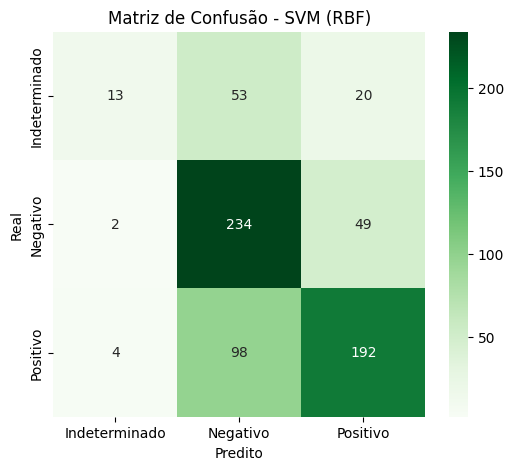

In [18]:
# Gerando matriz
cm_rf = confusion_matrix(y_test, rf_pred, labels=classes)
cm_svm = confusion_matrix(y_test, svm_pred, labels=classes)

# Plot matriz de confusão Random Forest
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Plot matriz de confusão SVM
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - SVM (RBF)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()